In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


from joblib import Parallel, delayed

import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sksurv.metrics import concordance_index_censored
import numpy as np
import scipy.stats
from functools import partial
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator


def mean_confidence_interval(data, confidence=0.95):
    """ Calculate mean, lower and upper bound of confidence interval """
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def Dxy(e,y,x):
    """ Calculate Dxy """
    #return 2 * concordance_index_censored(e, y, x)[0] - 1
    return 2 * concordance_index(y, x, e) - 1


def bootstrap_dxy_inner(df):
    e, y, x = df.columns
    sample = df.sample(df.shape[0], replace=True)
    
    # calculate Dxy
    return Dxy(sample[e], sample[y], sample[x])


def bootstrap_dxy(df, n=5):
    """ Boostrap and calculate Dxy """
    # resample n times
    result = Parallel(n_jobs=-1)(delayed(bootstrap_dxy_inner)(df) for i in range(n))

    return result

def apply_stats_for_each_value(df, fmap, condition_names=None):
    """ Apply stats to each value in column """

    all_count = df.shape[0]
    
    dff = pd.DataFrame({'E':df['E'], 'Y':df['Y'], 'agg':df.apply(fmap, axis=1)}).dropna()
    selected_count = dff.shape[0]
    
    stats = dff['Y'].aggregate(['count', 'median'])
    
    dxy_bootstraped = bootstrap_dxy(dff[['E', 'Y', 'agg']])
    # confidence interval
    dxy, ci_low, ci_high =  mean_confidence_interval(dxy_bootstraped)
    
    ret = {
        'Number of patiets' : stats['count'],
        '% z całej kohorty': np.round(selected_count/all_count, 2),
        'Survival days, median' : stats['median'],
        'Survival years, median' : stats['median']/365 ,
        'Dxy': np.round(dxy, 2), 
        'Confidence interval 95% low': np.round(ci_low, 2),
        'Confidence interval 95% high': np.round(ci_high, 2),
    }
    result = pd.DataFrame(ret, index=(0,))

    groups = dff.groupby(by=['agg'])['Y'].aggregate(['count', 'median', 'min', 'max', 'std','mean'])
    
    if condition_names:
        groups.index = groups.index.map(condition_names)
    #groups.columns = ['Number of patiets', 'Survival days, median', 'min', 'max', 'std']
    
    for value in dff["agg"].unique():
        mask = (dff["agg"] == value)
        time_cell, survival_prob_cell = kaplan_meier_estimator(dff["E"][mask], dff["Y"][mask])
        plt.step(time_cell, survival_prob_cell, where="post",
                 label="%s (n = %d)" % (condition_names[value], mask.sum()))

    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.show()
    plt.clf()
    return result, groups

In [2]:
DATA_PREFIX="~/secret_life_of_CVEs/data/"

In [3]:
unique_cve_info_cvss_cwe_etc_df_filename = DATA_PREFIX + 'unique_cve_info-cvss_cwe_etc.parquet'
cve_lifespan_language_df_filename = DATA_PREFIX + 'cve_lifespan_language_df'
unique_cve_info_cvss_cwe_etc_df = pd.read_parquet(unique_cve_info_cvss_cwe_etc_df_filename)
cve_lifespan_language_df_df = pd.read_parquet(cve_lifespan_language_df_filename)
commits_df = cve_lifespan_language_df_df.drop_duplicates()
commits_df['cve'] = commits_df['commit_cves']
df = commits_df.merge(unique_cve_info_cvss_cwe_etc_df.drop('error', axis='columns'), on='cve')

/tmp/ipykernel_3473437/572894398.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commits_df['cve'] = commits_df['commit_cves']


In [4]:
df.head()

,commit_cves,project_names,cve_lifespan_commiter_time,cve_lifespan_author_time,embargo_min,embargo_max,variable,value,programming_paradigm,compilation_class,...,cve,cvss,cwe,cvss-vector,access.authentication,access.complexity,access.vector,impact.availability,impact.confidentiality,impact.integrity
0,CVE-2014-3470,pagodabox_nanobox-pkgsrc-lite,339 days 00:11:42,344 days 01:42:00,False,False,lang_Ada,19.0,1,1,...,CVE-2014-3470,4.3,CWE-310,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE
1,CVE-2014-3470,bitbucket.org_cagney_netbsd,477 days 23:03:35,483 days 00:33:53,False,False,lang_Ada,241.0,1,1,...,CVE-2014-3470,4.3,CWE-310,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE
2,CVE-2014-3470,NetBSD_src,2 days 15:13:41,7 days 16:43:59,True,False,lang_Assembly,4.0,1,1,...,CVE-2014-3470,4.3,CWE-310,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE
3,CVE-2014-3470,pagodabox_nanobox-pkgsrc-lite,339 days 00:11:42,344 days 01:42:00,False,False,lang_Assembly,18.0,1,1,...,CVE-2014-3470,4.3,CWE-310,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE
4,CVE-2014-3470,bitbucket.org_cagney_netbsd,477 days 23:03:35,483 days 00:33:53,False,False,lang_Assembly,1744.0,1,1,...,CVE-2014-3470,4.3,CWE-310,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE


In [5]:
df.columns

Index(['commit_cves', 'project_names', 'cve_lifespan_commiter_time',
       'cve_lifespan_author_time', 'embargo_min', 'embargo_max', 'variable',
       'value', 'programming_paradigm', 'compilation_class', 'type_class',
       'memory_model', 'extended_programming_paradigm', 'cve', 'cvss', 'cwe',
       'cvss-vector', 'access.authentication', 'access.complexity',
       'access.vector', 'impact.availability', 'impact.confidentiality',
       'impact.integrity'],
      dtype='object')

In [6]:
df['E'] = True
df['Y']=df['cve_lifespan_commiter_time'].dt.days

#df_org = df.copy()
#df = df[df['embargo_max'] == True]
#df = df[df['Y']<=365]

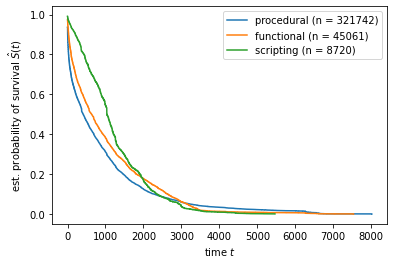

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,375523.0,1.0,456.0,1.249315,0.04,0.04,0.04


,count,median,min,max,std,mean
agg,,,,,,
procedural,321742,412.0,0,8019,1212.068708,877.223157
scripting,8720,1036.0,0,5465,865.711022,1193.360665
functional,45061,636.0,0,7538,1088.766822,1006.655511


(None, None)

<Figure size 432x288 with 0 Axes>

In [7]:
def f_map_pp(x):
    a = int(x['programming_paradigm'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    if a == 3:
        return 3
    else:
        return 0

condition_names_pp = {1 : 'procedural', 2: 'scripting', 3:'functional', 0: 'other'}

S1, S2 = apply_stats_for_each_value(df, f_map_pp, condition_names_pp)
display(S1), display(S2)

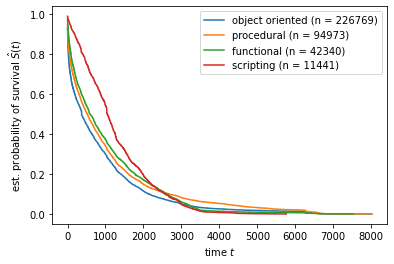

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,375523.0,1.0,456.0,1.249315,0.02,0.02,0.03


,count,median,min,max,std,mean
agg,,,,,,
functional,42340,592.0,0,7538,1088.964797,985.779216
object oriented,226769,370.0,0,8019,1143.410455,821.481830
procedural,94973,521.0,0,8019,1352.828369,1010.317880
scripting,11441,1048.0,0,5766,910.109767,1226.214230


(None, None)

<Figure size 432x288 with 0 Axes>

In [8]:
def f_map_epp(x):
    a = int(x['extended_programming_paradigm'])
    if a == 1:
        return 1
    if a == 2:
        return 2
    if a == 3:
        return 3
    if a == 4:
        return 4
    else:
        return 0

condition_names_epp = {1 : 'functional', 2: 'object oriented', 3:'procedural', 4:'scripting', 0: 'other'}

S1, S2 = apply_stats_for_each_value(df, f_map_epp, condition_names_epp)
display(S1), display(S2)

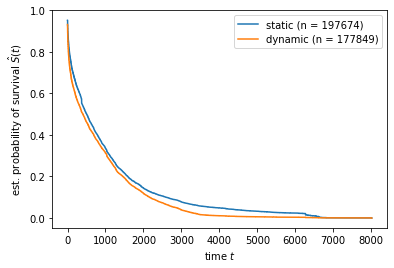

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,375523.0,1.0,456.0,1.249315,-0.04,-0.04,-0.04


,count,median,min,max,std,mean
agg,,,,,,
static,197674,504.0,0,8019,1343.922605,996.183165
dynamic,177849,406.0,0,8019,986.777483,793.296735


(None, None)

<Figure size 432x288 with 0 Axes>

In [9]:
def f_map_cc(x):
    a = int(x['compilation_class'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    else:
        return 0

condition_names_cc = {1 : 'static', 2: 'dynamic', 0: 'other'}

S1, S2 = apply_stats_for_each_value(df, f_map_cc, condition_names_cc)
display(S1), display(S2)

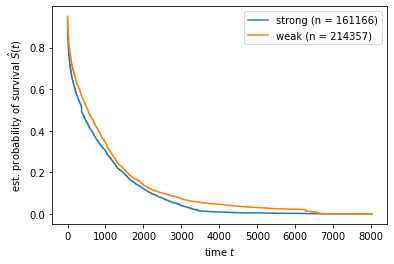

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,375523.0,1.0,456.0,1.249315,0.04,0.04,0.04


,count,median,min,max,std,mean
agg,,,,,,
strong,161166,370.0,0,8019,982.491323,781.815054
weak,214357,535.0,0,8019,1321.832146,989.025490


(None, None)

<Figure size 432x288 with 0 Axes>

In [10]:
def f_map_tc(x):
    a = int(x['type_class'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    else:
        return 0

condition_names_tc = {1 : 'strong', 2: 'weak', 0: 'other'}

S1, S2 = apply_stats_for_each_value(df, f_map_tc, condition_names_tc)
display(S1), display(S2)

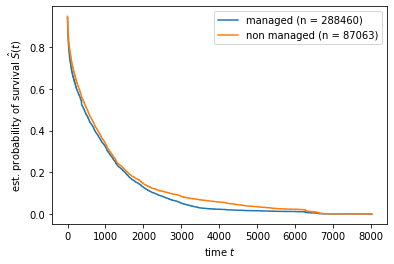

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,375523.0,1.0,456.0,1.249315,0.02,0.02,0.02


,count,median,min,max,std,mean
agg,,,,,,
managed,288460,440.0,0,8019,1128.54338,865.167625
non managed,87063,521.0,0,8019,1377.28904,1015.819453


(None, None)

<Figure size 432x288 with 0 Axes>

In [11]:
def f_map_mm(x):
    a = int(x['memory_model'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    else:
        return 0

condition_names_mm = {1 : 'managed', 2: 'non managed', 0: 'other'}

S1, S2 = apply_stats_for_each_value(df, f_map_mm, condition_names_mm)
display(S1), display(S2)

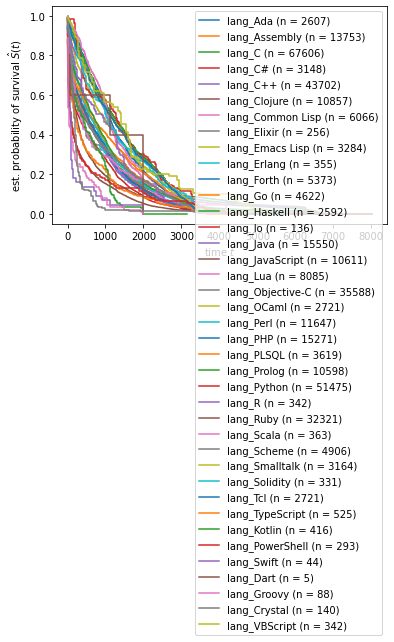

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,375523.0,1.0,456.0,1.249315,-0.07,-0.07,-0.07


,count,median,min,max,std,mean
agg,,,,,,
lang_Ada,2607,1177.0,0,5766,1029.174806,1375.394707
lang_Assembly,13753,588.0,0,7538,921.453446,892.290846
lang_C,67606,448.0,0,8019,1479.137610,1019.291468
lang_C#,3148,1137.0,0,5766,1089.575193,1353.523189
lang_C++,43702,437.0,0,8019,1385.206390,946.933916
lang_Clojure,10857,227.0,0,7538,943.749824,620.311320
lang_Common Lisp,6066,1033.0,0,7538,1036.973382,1253.856413
lang_Elixir,256,363.5,0,4791,1024.549684,882.476562
lang_Emacs Lisp,3284,905.0,0,5766,1046.181068,1200.002132


(None, None)

<Figure size 432x288 with 0 Axes>

In [12]:
languagesl = df['variable'].unique()

languages = dict(zip(languagesl, range(len(languagesl))))

condition_names_languages = dict(zip(range(len(languagesl)), languagesl))

def f_map_languages(x):
    a = x['variable']
    return languages[a]


S1, S2 = apply_stats_for_each_value(df, f_map_languages, condition_names_languages)
display(S1), display(S2)

In [13]:
df.head()

,commit_cves,project_names,cve_lifespan_commiter_time,cve_lifespan_author_time,embargo_min,embargo_max,variable,value,programming_paradigm,compilation_class,...,cwe,cvss-vector,access.authentication,access.complexity,access.vector,impact.availability,impact.confidentiality,impact.integrity,E,Y
0,CVE-2014-3470,pagodabox_nanobox-pkgsrc-lite,339 days 00:11:42,344 days 01:42:00,False,False,lang_Ada,19.0,1,1,...,CWE-310,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE,True,339
1,CVE-2014-3470,bitbucket.org_cagney_netbsd,477 days 23:03:35,483 days 00:33:53,False,False,lang_Ada,241.0,1,1,...,CWE-310,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE,True,477
2,CVE-2014-3470,NetBSD_src,2 days 15:13:41,7 days 16:43:59,True,False,lang_Assembly,4.0,1,1,...,CWE-310,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE,True,2
3,CVE-2014-3470,pagodabox_nanobox-pkgsrc-lite,339 days 00:11:42,344 days 01:42:00,False,False,lang_Assembly,18.0,1,1,...,CWE-310,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE,True,339
4,CVE-2014-3470,bitbucket.org_cagney_netbsd,477 days 23:03:35,483 days 00:33:53,False,False,lang_Assembly,1744.0,1,1,...,CWE-310,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE,True,477


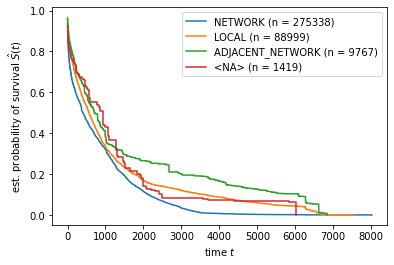

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,375523.0,1.0,456.0,1.249315,0.05,0.05,0.05


,count,median,min,max,std,mean
agg,,,,,,
NETWORK,275338,405.0,0,8019,933.500756,783.074705
LOCAL,88999,566.0,0,7538,1617.497676,1176.280284
ADJACENT_NETWORK,9767,708.0,0,6839,2074.502818,1635.202826
<NA>,1419,924.0,0,6012,1515.508219,1224.470754


(None, None)

<Figure size 432x288 with 0 Axes>

In [14]:
languagesl = df['access.vector'].unique()

languages = dict(zip(languagesl, range(len(languagesl))))

condition_names_mm = dict(zip(range(len(languagesl)), languagesl))

def f_map_mm(x):
    a = x['access.vector']
    return languages[a]


S1, S2 = apply_stats_for_each_value(df, f_map_mm, condition_names_mm)
display(S1), display(S2)

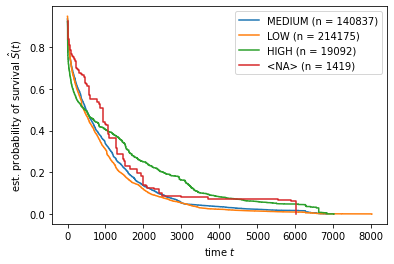

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,375523.0,1.0,456.0,1.249315,-0.01,-0.01,-0.01


,count,median,min,max,std,mean
agg,,,,,,
MEDIUM,140837,488.0,0,6820,1220.578034,933.548954
LOW,214175,428.0,0,8019,1100.181720,840.363978
HIGH,19092,455.0,0,7022,1737.394991,1299.278703
<NA>,1419,924.0,0,6012,1515.508219,1224.470754


(None, None)

<Figure size 432x288 with 0 Axes>

In [15]:
languagesl = df['access.complexity'].unique()

languages = dict(zip(languagesl, range(len(languagesl))))

condition_names_mm = dict(zip(range(len(languagesl)), languagesl))

def f_map_mm(x):
    a = x['access.complexity']
    return languages[a]


S1, S2 = apply_stats_for_each_value(df, f_map_mm, condition_names_mm)
display(S1), display(S2)

In [16]:
def naive_compute(df_in, vname, typesl=None):

    print(vname)
    if typesl is None:
        typesl = df_in[vname].dropna().unique()

    types = dict(zip(typesl, range(len(typesl))))
    print(types)


    condition_names_mm = dict(zip(range(len(typesl)), typesl))

    def f_map_mm(x):
        try:
            a = x[vname]
            return types[a]
        except:
            return None


    S1, S2 = apply_stats_for_each_value(df_in, f_map_mm, condition_names_mm)
    display(S1), display(S2)

In [17]:
vnames = ['programming_paradigm', 'compilation_class', 'type_class',
       'memory_model']#, 'access.authentication', 'access.complexity', 'access.vector',
       #'impact.availability', 'impact.confidentiality', 'impact.integrity']

programming_paradigm
{1: 0, 3: 1, 2: 2}


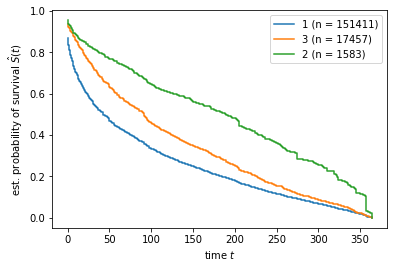

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,170451.0,1.0,49.0,0.134247,0.05,0.04,0.05


,count,median,min,max,std,mean
agg,,,,,,
1,151411,43.0,0,364,104.218930,90.189114
3,17457,91.0,0,364,106.741388,120.306754
2,1583,189.0,0,364,125.841002,180.602021


compilation_class
{1: 0, 2: 1}


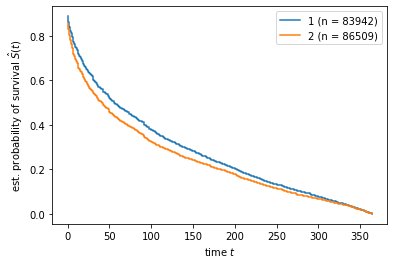

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,170451.0,1.0,49.0,0.134247,-0.04,-0.04,-0.04


,count,median,min,max,std,mean
agg,,,,,,
1,83942,56.0,0,364,106.608447,100.118761
2,86509,41.0,0,364,103.943792,88.286109


type_class
{1: 0, 2: 1}


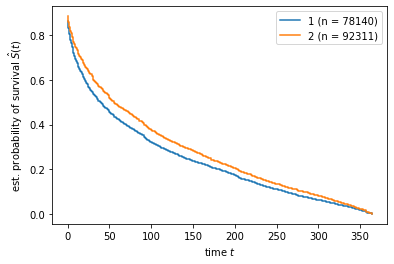

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,170451.0,1.0,49.0,0.134247,0.04,0.04,0.04


,count,median,min,max,std,mean
agg,,,,,,
1,78140,40.0,0,364,102.665846,86.848759
2,92311,56.0,0,364,107.331859,100.262699


memory_model
{1: 0, 2: 1}


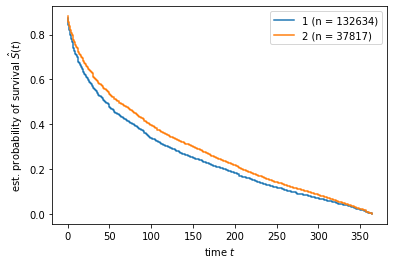

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,170451.0,1.0,49.0,0.134247,0.02,0.02,0.03


,count,median,min,max,std,mean
agg,,,,,,
1,132634,45.0,0,364,104.325789,91.300594
2,37817,61.0,0,364,108.643056,103.978343


<Figure size 432x288 with 0 Axes>

In [18]:
for v in vnames:
    naive_compute(df[df['Y'] < 365], v)

In [19]:
df['cvss-vector'].unique()

<StringArray>
['AV:N/AC:M/Au:N/C:N/I:N/A:P', 'AV:N/AC:M/Au:N/C:P/I:P/A:P',
 'AV:N/AC:L/Au:N/C:N/I:N/A:P', 'AV:N/AC:M/Au:N/C:P/I:P/A:N',
 'AV:N/AC:L/Au:N/C:C/I:C/A:C', 'AV:N/AC:M/Au:N/C:P/I:N/A:N',
 'AV:N/AC:L/Au:N/C:P/I:N/A:N', 'AV:N/AC:M/Au:N/C:C/I:C/A:C',
 'AV:N/AC:L/Au:N/C:P/I:P/A:P', 'AV:N/AC:L/Au:N/C:N/I:N/A:C',
 ...
 'AV:L/AC:L/Au:S/C:C/I:N/A:N', 'AV:N/AC:L/Au:M/C:N/I:P/A:N',
 'AV:N/AC:H/Au:M/C:C/I:C/A:C', 'AV:N/AC:L/Au:M/C:N/I:N/A:P',
 'AV:N/AC:H/Au:N/C:C/I:C/A:N', 'AV:L/AC:M/Au:N/C:N/I:C/A:N',
 'AV:N/AC:L/Au:N/C:N/I:P/A:C', 'AV:L/AC:L/Au:S/C:P/I:N/A:P',
 'AV:N/AC:L/Au:N/C:N/I:C/A:P', 'AV:N/AC:M/Au:N/C:C/I:P/A:P']
Length: 221, dtype: string

In [20]:
#global_names = []
#global_values = []
#set(global_names), set(global_values)

def decode_cvssvector(name):
    ret = {'cvssv_A': None, 'cvssv_AC': None, 'cvssv_AV': None, 'cvssv_Au': None, 'cvssv_C': None, 'cvssv_I': None}
    if not isinstance(name, str):
        #print("Error not string")
        return ret
    kvs = name.split("/")
    for kv in kvs:
        k,v = kv.split(":")
        #global_names.append(k)
        #global_values.append(v)
        #if k in ret:
        #    print("Error " + name)
        ret['cvssv_'+k] = v
    return ret

In [21]:
d = df['cvss-vector'].map(decode_cvssvector)

In [22]:
Z = pd.DataFrame(d.tolist())

In [23]:
Z['cvssv_AV'].unique()

array(['N', 'L', 'A', None], dtype=object)

In [24]:
df_ext = pd.concat([df, Z], axis=1)

['P' 'N' 'C']
cvssv_A
{'N': 0, 'P': 1, 'C': 2}


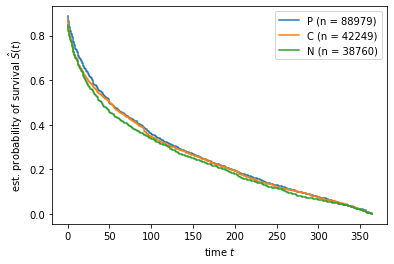

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,169988.0,1.0,49.0,0.134247,0.01,0.01,0.01


,count,median,min,max,std,mean
agg,,,,,,
N,38760,41.0,0,364,103.706206,88.896620
P,88979,50.0,0,364,105.837934,96.502456
C,42249,50.0,0,364,106.041645,94.032001


['M' 'L' 'H']
cvssv_AC
{'L': 0, 'M': 1, 'H': 2}


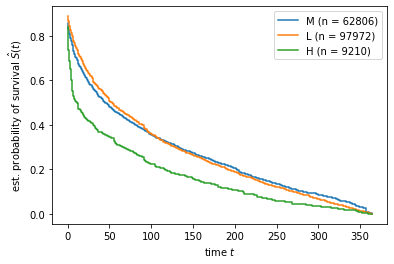

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,169988.0,1.0,49.0,0.134247,-0.04,-0.04,-0.04


,count,median,min,max,std,mean
agg,,,,,,
L,97972,53.0,0,364,103.317034,95.879547
M,62806,46.0,0,364,109.998760,96.408767
H,9210,11.0,0,364,89.274054,60.425950


['N' 'L' 'A']
cvssv_AV
{'L': 0, 'A': 1, 'N': 2}


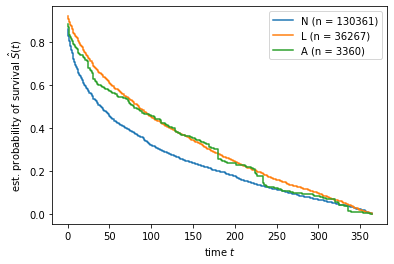

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,169988.0,1.0,49.0,0.134247,-0.07,-0.07,-0.07


,count,median,min,max,std,mean
agg,,,,,,
L,36267,85.0,0,364,108.486938,117.307635
A,3360,79.0,0,364,106.385058,111.417560
N,130361,40.0,0,364,103.584019,87.267849


['N' 'S' 'M']
cvssv_Au
{'N': 0, 'S': 1, 'M': 2}


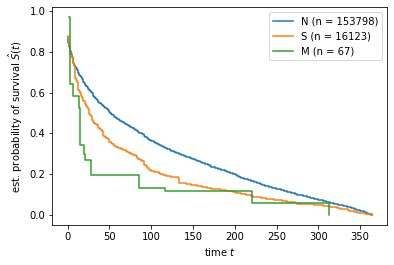

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,169988.0,1.0,49.0,0.134247,-0.03,-0.03,-0.02


,count,median,min,max,std,mean
agg,,,,,,
N,153798,51.0,0,364,106.539284,97.020852
S,16123,26.0,0,364,90.042256,67.003721
M,67,15.0,2,313,86.204481,47.298507


['N' 'P' 'C']
cvssv_C
{'N': 0, 'P': 1, 'C': 2}


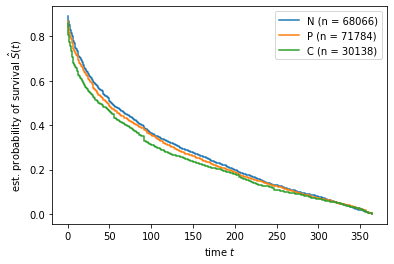

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,169988.0,1.0,49.0,0.134247,-0.03,-0.04,-0.03


,count,median,min,max,std,mean
agg,,,,,,
N,68066,52.0,0,364,105.842068,98.008991
P,71784,48.0,0,364,105.408558,93.845077
C,30138,38.0,0,364,104.193600,86.184485


['N' 'P' 'C']
cvssv_I
{'N': 0, 'P': 1, 'C': 2}


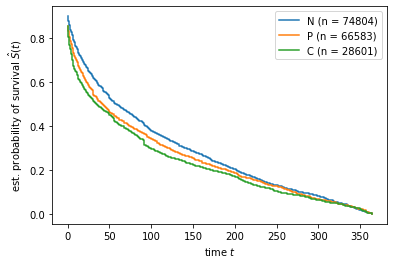

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,169988.0,1.0,49.0,0.134247,-0.06,-0.06,-0.05


,count,median,min,max,std,mean
agg,,,,,,
N,74804,59.0,0,364,105.933572,101.169349
P,66583,42.0,0,364,105.469185,90.958503
C,28601,34.0,0,364,102.818532,83.246075


<Figure size 432x288 with 0 Axes>

In [25]:
cvss_v = {'A':'-', 'AC':'-', 'AV':'-', 'Au':'-', 'C':'-', 'I':'-'}
# order by https://qualysguard.qg2.apps.qualys.com/qwebhelp/fo_portal/setup/cvss_vector_strings.htm
cvss_order = {
    'AV':['L','A','N'],
    'AC':['L','M','H'],
    
    'Au':['N','S','M'],

    'C':['N','P','C'],
    'A':['N','P','C'],
    'I':['N','P','C'],
}
for k in cvss_v.keys():
    key = 'cvssv_'+k
    #df_ext[key].fillna('-', inplace=True)
    print(df_ext[key].dropna().unique())
    if k in cvss_order:
        naive_compute(df_ext[df_ext['Y'] < 365], key, cvss_order[k])
    else:
        print("Error")
    #naive_compute(df_ext, key)

In [26]:
df_ext['Y']

0         339
1         477
2           2
3         339
4         477
         ... 
375518      0
375519      0
375520    869
375521    108
375522     76
Name: Y, Length: 375523, dtype: int64

# Tiobe

In [27]:
tiobe = pd.read_csv("../data/tiobe.csv", index_col=False)

In [28]:
tiobe['language'].unique()

array(['Python', 'C', 'C++', 'Java', 'C#', 'Visual Basic', 'JavaScript',
       'SQL', 'Assembly language', 'PHP', 'R', 'Go',
       'Classic Visual Basic', 'MATLAB', 'Swift', 'Delphi/Object Pascal',
       'Ruby', 'Perl', 'Objective-C', 'Rust', 'Scratch', 'SAS', 'Kotlin',
       'Julia', 'Lua', 'Fortran', 'COBOL', 'Lisp', '(Visual) FoxPro',
       'Ada', 'Dart', 'Scala', 'Prolog', 'D', 'PL/SQL', 'Bash',
       'PowerShell', 'Haskell', 'Logo', 'Transact-SQL', 'TypeScript',
       'ABAP', 'F#', 'OCaml', 'CFML', 'Scheme', 'Erlang', 'LabVIEW',
       'Groovy', 'ML', 'ABC', 'ActionScript', 'Alice', 'Apex', 'APL',
       'AutoLISP', 'Awk', 'B4X', 'C shell', 'CL (OS/400)', 'CLIPS',
       'Clojure', 'Common Lisp', 'Crystal', 'Elixir', 'Emacs Lisp',
       'Forth', 'Hack', 'Icon', 'Io', 'J#', 'JScript', 'Korn shell',
       'Ladder Logic', 'LPC', 'Modula-2', 'MQL5', 'MUMPS', 'NATURAL',
       'Occam', 'OpenCL', 'OpenEdge ABL', 'PL/I', 'Q', 'Racket', 'Raku',
       'Ring', 'RPG', 'S', 'Smallta

In [29]:
df['lang'] = df['variable'].map(lambda x: x.split("_")[1])
df['lang'][df['lang'] == 'PLSQL'] = 'SQL'

/tmp/ipykernel_3473437/490945153.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lang'][df['lang'] == 'PLSQL'] = 'SQL'


In [30]:
df_tiobe = df.merge(tiobe[['language', 'dec2022']], how="left", left_on="lang", right_on="language")

In [31]:
df_tiobe[df_tiobe['language'].isna()]['lang'].unique()

array(['Assembly'], dtype=object)

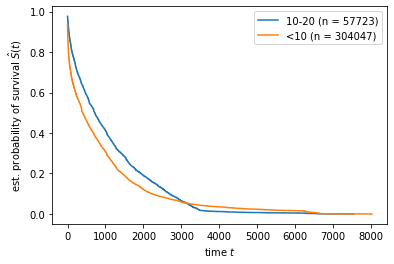

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,361770.0,0.96,451.0,1.235616,0.05,0.05,0.05


,count,median,min,max,std,mean
agg,,,,,,
<10,304047,398.0,0,8019,1220.751729,869.499857
10-20,57723,717.0,0,7538,1081.038032,1063.112503


(None, None)

<Figure size 432x288 with 0 Axes>

In [32]:
def f_map_cc(x):
    try:
        a = int(x['dec2022'])
        return int((a + 1) / 30)
    except:
        return None

condition_names_cc = {0 : '<10', 1: '10-20', 2: '20-30', 3: '30-40', 4:'40-50', 5: '50-100' }

S1, S2 = apply_stats_for_each_value(df_tiobe, f_map_cc, condition_names_cc)
display(S1), display(S2)

In [33]:
int(21/10)

2

In [34]:
tiobe[(tiobe['dec2022']>=30)&(tiobe['dec2022']<40)]

,dec2022,dec2021,change,language,ratings,change.1
29,30,NaN,NaN,Ada,0.38%,NaN
30,31,NaN,NaN,Dart,0.30%,NaN
31,32,NaN,NaN,Scala,0.29%,NaN
32,33,NaN,NaN,Prolog,0.29%,NaN
33,34,NaN,NaN,D,0.28%,NaN
34,35,NaN,NaN,PL/SQL,0.27%,NaN
35,36,NaN,NaN,Bash,0.24%,NaN
36,37,NaN,NaN,PowerShell,0.23%,NaN
37,38,NaN,NaN,Haskell,0.22%,NaN
38,39,NaN,NaN,Logo,0.22%,NaN


In [35]:
df_tiobe[df_tiobe['lang'].str.match('SQL')]['value'].unique()

array([  2.,  48.,   4.,   1.,   3.,  11.,  23.,   5.,   7.,  35.,  17.,
        25.,  13.,  36.,  18., 173., 169.,  12.,  55.,  15.,   8.,   9.,
        27.,  34.,  47.,  80.,  10.,  14.,  16.,   6.,  91.,  26.,  31.,
        81., 254.,  20.,  72.,  21.,  22.])

In [36]:
tiobe[(tiobe['dec2022']>=40)&(tiobe['dec2022']<50)]

,dec2022,dec2021,change,language,ratings,change.1
39,40,NaN,NaN,Transact-SQL,0.21%,NaN
40,41,NaN,NaN,TypeScript,0.21%,NaN
41,42,NaN,NaN,ABAP,0.19%,NaN
42,43,NaN,NaN,F#,0.19%,NaN
43,44,NaN,NaN,OCaml,0.18%,NaN
44,45,NaN,NaN,CFML,0.17%,NaN
45,46,NaN,NaN,Scheme,0.17%,NaN
46,47,NaN,NaN,Erlang,0.15%,NaN
47,48,NaN,NaN,LabVIEW,0.15%,NaN
48,49,NaN,NaN,Groovy,0.14%,NaN


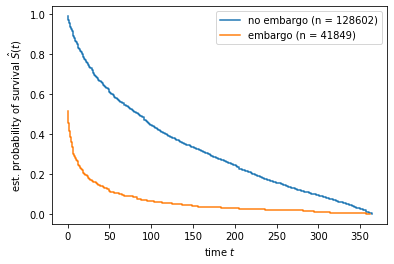

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,170451.0,1.0,49.0,0.134247,-0.28,-0.28,-0.28


,count,median,min,max,std,mean
agg,,,,,,
no embargo,128602,85.0,0,364,107.191958,117.654912
embargo,41849,1.0,0,362,55.026649,21.770054


(None, None)

<Figure size 432x288 with 0 Axes>

In [37]:
def f_map_cc(x):
    return x['embargo_max']


condition_names_cc = {True : 'embargo', False:  'no embargo'  }

S1, S2 = apply_stats_for_each_value(df[df['Y'] < 365], f_map_cc, condition_names_cc)
display(S1), display(S2)

In [ ]:
def f_map_cc(x):
    return x['embargo_min']


condition_names_cc = {True : 'embargo', False:  'no embargo'  }

S1, S2 = apply_stats_for_each_value(df[df['Y'] < 365], f_map_cc, condition_names_cc)
display(S1), display(S2)

In [ ]:
df['cvss']

In [ ]:

# https://www.balbix.com/insights/understanding-cvss-scores/ 

#cvss3r_s = pd.cut(df['cvss'],
#                  bins=[0,0.1,4,7,9,10.1],right=False,include_lowest=True,
#                  labels=['None','Low','Medium','High','Critical'])
#df['CVSS v3.1 Ratings'] = cvss3r_s
#df.value_counts('CVSS v3.1 Ratings')

def f_map(x):
    try:
        a = int(x['cvss'])
        if a < 0.1:
            return None
        if a >= 0.1 and a <4:
            return 1
        if a >= 4 and a < 7:
            return 2
        if a > 7 and a < 9:
            return 3
        if 9 >= a and a <= 10:
            return 4
        else:
            return None
    except:
        return None

condition_names = { 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Critical'}


S1, S2 = apply_stats_for_each_value(df[df['Y'] < 365], f_map, condition_names)
display(S1), display(S2)

In [ ]:
S1, S2 = apply_stats_for_each_value(df[df['Y'] < 100], f_map, condition_names)
display(S1), display(S2)

In [ ]:
S1, S2 = apply_stats_for_each_value(df, f_map, condition_names)
display(S1), display(S2)

In [ ]:
(df['embargo_min'] == df['embargo_max']).sum()/len(df)

# Programming languages categories

In [ ]:
curly_bracked =["ABCL/c+", "Alef", "AWK", "B", "bc", "BCPL", "Ballerina", "C", "C++", "C#", "Ceylon", "ChucK", "Cilk", "Cyclone", "D", "Dart", "DASL", "E", "eC", "ECMAScript", "ActionScript", "ECMAScript", "JavaScript", "JScript", "TypeScript", "GLSL", "Go (Golang)", "HLSL", "ICI", "Java", "Processing", "Groovy", "Join Java", "Kotlin", "Tea", "X10", "Limbo", "LPC", "MEL", "Objective-C", "PCASTL", "Perl", "PHP", "Pico", "Pike", "PowerShell", "R", "Rust", "S-Lang", "Scala", "sed", "Solidity", "SuperCollider", "Swift", "UnrealScript", "Yorick", "YASS",]
curly_bracked = [l.lower() for l in curly_bracked]

In [ ]:
df['lang'] = df['variable'].map(lambda x: x.split("_")[1])

In [ ]:
df["language.curly_bracked"] = df['lang'].map(lambda x: True if x.lower() in curly_bracked else False)

In [ ]:
df["language.curly_bracked"].sum()/len(df)

In [ ]:
def f_map(x):
    return int(x['language.curly_bracked'])


condition_names = { 0: 'other', 1: 'curly_bracked'}


S1, S2 = apply_stats_for_each_value(df[df['Y'] < 365], f_map, condition_names)
display(S1), display(S2)

In [ ]:
def f_map(x):
    return int(x['language.curly_bracked'])


condition_names = { 0: 'other', 1: 'curly_bracked'}


S1, S2 = apply_stats_for_each_value(df[df['Y'] < 100], f_map, condition_names)
display(S1), display(S2)

In [ ]:
def f_map(x):
    return int(x['language.curly_bracked'])


condition_names = { 0: 'other', 1: 'curly_bracked'}


S1, S2 = apply_stats_for_each_value(df, f_map, condition_names)
display(S1), display(S2)